In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('data/avocado.csv')

In [4]:
data.shape

(18249, 14)

In [5]:
data['Day'], data['Month'] = data.Date.str[:2], data.Date.str[3:5]

In [6]:
data = data.drop(['Unnamed: 0', 'Date'], axis = 1)

In [7]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248
AveragePrice,1.33,1.35,0.93,1.08,1.28,1.26,0.99,0.98,1.02,1.07,...,1.56,1.54,1.57,1.56,1.57,1.63,1.71,1.87,1.93,1.62
Total Volume,64236.6,54877,118220,78992.1,51039.6,55979.8,83453.8,109428,99811.4,74338.8,...,22128.4,17393.3,18421.2,17597.1,15986.2,17074.8,13888,13766.8,16205.2,17489.6
4046,1036.74,674.28,794.7,1132,941.48,1184.27,1368.92,703.75,1022.15,842.4,...,2162.67,1832.24,1974.26,1892.05,1924.28,2046.96,1191.7,1191.92,1527.63,2894.77
4225,54454.8,44638.8,109150,71976.4,43838.4,48068,73672.7,101815,87315.6,64757.4,...,3194.25,1905.57,2482.65,1928.36,1368.32,1529.2,3431.5,2452.79,2981.04,2356.13
4770,48.16,58.33,130.5,72.58,75.78,43.61,93.26,80,85.34,113,...,8.93,0,0,0,0,0,0,727.94,727.01,224.53
Total Bags,8696.87,9505.56,8145.35,5811.16,6183.95,6683.91,8318.86,6829.22,11388.4,8625.92,...,16762.6,13655.5,13964.3,13776.7,12693.6,13498.7,9264.84,9394.11,10969.5,12014.1
Small Bags,8603.62,9408.07,8042.21,5677.4,5986.26,6556.47,8196.81,6266.85,11104.5,8061.47,...,16510.3,13401.9,13698.3,13553.5,12437.4,13066.8,8940.04,9351.8,10919.5,11988.1
Large Bags,93.25,97.49,103.14,133.76,197.69,127.44,122.05,562.37,283.83,564.45,...,252.25,253.56,266.06,223.18,256.22,431.85,324.8,42.31,50,26.01
XLarge Bags,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
type,conventional,conventional,conventional,conventional,conventional,conventional,conventional,conventional,conventional,conventional,...,organic,organic,organic,organic,organic,organic,organic,organic,organic,organic


In [8]:
data = data.dropna()

In [9]:
label_dict = defaultdict(LabelEncoder)

In [10]:
data[['region', 'type', 'Day', 'Month', 'year']] = data[['region', 'type', 'Day', 'Month', 'year']].apply(lambda x: label_dict[x.name].fit_transform(x))

In [11]:
X = data
y = X.pop('AveragePrice')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

Bring data in the proper format for the model

In [12]:
cat_cols_dict = {col: list(data[col].unique()) for col in ['region', 'type', 'Day', 'Month', 'year']}

In [13]:
train_input_list = []
test_input_list = []

for col in cat_cols_dict.keys():
    raw_values = np.unique(data[col])
    value_map = {}
    for i in range(len(raw_values)):
        value_map[raw_values[i]] = i       
    train_input_list.append(X_train[col].map(value_map).values)
    test_input_list.append(X_test[col].map(value_map).fillna(0).values)


other_cols = [col for col in data.columns if (not col in cat_cols_dict.keys())]
train_input_list.append(X_train[other_cols].values)
test_input_list.append(X_test[other_cols].values)

In [14]:
cols_out_dict = {
    'region': 12, 
    'type': 1, 
    'Day': 10, 
    'Month': 3, 
    'year': 1
}

In [15]:
inputs = []
embeddings = []

for col in cat_cols_dict.keys():
    
    inp = Input(shape=(1,), name = 'input_' + col)
    embedding = Embedding(len(cat_cols_dict[col]), cols_out_dict[col], input_length=1, name = 'embedding_' + col)(inp)
    embedding = Reshape(target_shape=(cols_out_dict[col],))(embedding)
    inputs.append(inp)
    embeddings.append(embedding)


input_numeric = Input(shape=(8,))
embedding_numeric = Dense(16)(input_numeric) 
inputs.append(input_numeric)
embeddings.append(embedding_numeric)

x = Concatenate()(embeddings)
x = Dense(16, activation='relu')(x)
x = Dense(4, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs, output)

model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_region (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
input_type (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
input_Day (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_Month (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
input_year

In [17]:
model.fit(train_input_list, y_train, validation_data = (test_input_list, y_test), epochs=50, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 12774 samples, validate on 5475 samples
Epoch 1/50
12774/12774 [==============================] - 2s 124us/step - loss: 53295180743.5138 - val_loss: 286530513.3150
Epoch 2/50
12774/12774 [==============================] - 1s 59us/step - loss: 121049092.4849 - val_loss: 43968444.5480
Epoch 3/50
12774/12774 [==============================] - 1s 60us/step - loss: 26135176.1193 - val_loss: 15038244.8321
Epoch 4/50
12774/12774 [==============================] - 1s 59us/step - loss: 10282040.9579 - val_loss: 7312467.7255
Epoch 5/50
12774/12774 [==============================] - 1s 57us/step - loss: 5610835.5616 - val_loss: 4212715.4917
Epoch 6/50
12774/12774 [==============================] - 1s 57us/step - loss: 3284640.9104 - val_loss: 2626078.3302
Epoch 7/50
12774/12774 [==============================] - 1s 63us/step - loss: 1985170.2991 - val_loss: 1682499.5763
Epoch 8/50
12774/12774 [==============================] - 1s 61us/step 

In [18]:
model.evaluate(test_input_list, y_test)

5475/5475 [==============================] - 0s 54us/step


3.112497390557642

In [33]:
embedding_region = model.get_layer('embedding_region').get_weights()[0]
embedding_Day = model.get_layer('embedding_Day').get_weights()[0]
embedding_Month = model.get_layer('embedding_Month').get_weights()[0]

In [34]:
label_dict['region'].inverse_transform(cat_cols_dict['region'])

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

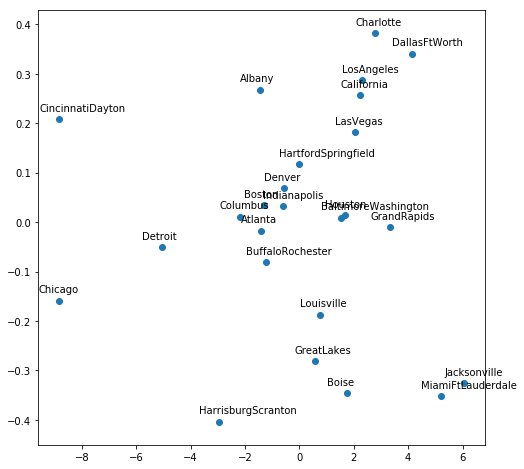

In [48]:
pca = PCA(n_components=2)
Y = pca.fit_transform(embedding_region[:25])
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate((label_dict['region'].inverse_transform(cat_cols_dict['region']))[:25]):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.show()

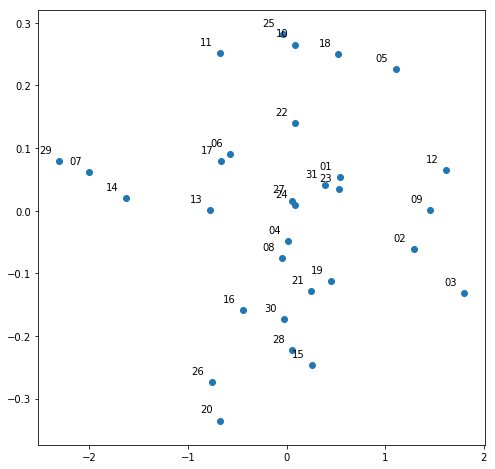

In [26]:
pca = PCA(n_components=2)
Y = pca.fit_transform(embedding_Day)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(label_dict['Day'].inverse_transform(cat_cols_dict['Day'])):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.show()

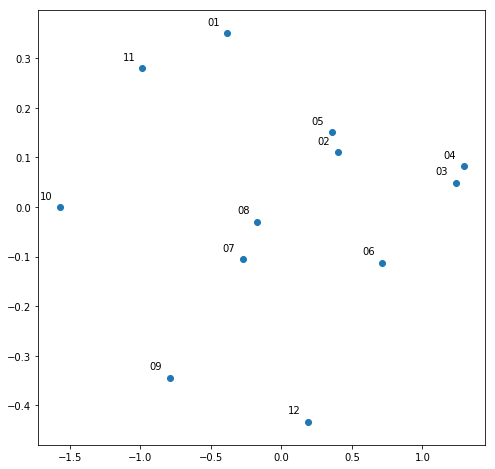

In [27]:
pca = PCA(n_components=2)
Y = pca.fit_transform(embedding_Month)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:20, 0], -Y[:20, 1])
for i, txt in enumerate(label_dict['Month'].inverse_transform(cat_cols_dict['Month'])):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
    if i == 20:
        break
plt.show()